In [5]:
import pandas as pd
import random
import numpy as np

In [6]:
with open('stopwords-hu.txt', 'r', encoding='utf-8') as file:
    # Read all lines and strip whitespace, filter out empty lines
    stopwords = [line.strip() for line in file if line.strip()]

In [7]:
hungarian_multigraph_letters = ['cs', 'dz', 'dzs', 'gy', 'ly', 'ny', 'sz', 'ty', 'zs']

In [8]:
def get_corpus():
    df = pd.read_csv('words_hu.csv', on_bad_lines='skip', dtype=str)

    prefix_pattern = '^(meg|át|fel|el|be|ki|elő|le|vissza|oda|ide|túl|körül|kör|felül|alul|kívül|belül|hátul|elől|hátra|előre|össze|szét|újra|felre|alá|oldal)'
    df = df[
        df['szavak'].notna() &
        (df['szavak'].str.contains(prefix_pattern, regex=True, na=False) == False)
    ]

    # keep only A–Z + a–z + Hungarian letters
    letters_only = r'^[A-Za-zÁÉÍÓÖŐÚÜŰáéíóöőúüű]+$'
    df = df[df['szavak'].str.contains(letters_only, regex=True, na=False)]

    df['szavak'] = df['szavak'].str.lower()

    # Drop stopwords
    df = df[~df['szavak'].isin(stopwords)]

    # Drop 1 letters
    df = df[~df['szavak'].isin(hungarian_multigraph_letters)]

    df = df.drop_duplicates(subset=['szavak'])
    df = df[df['szavak'].str.len() > 1]

    CORPUS = df['szavak'].values
    random.shuffle(CORPUS)
    return CORPUS


In [9]:
corpus = get_corpus()

/var/folders/59/v5dbhk2s3xx2rh5prvb8hs7r0000gn/T/ipykernel_32175/3944634639.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  (df['szavak'].str.contains(prefix_pattern, regex=True, na=False) == False)


In [10]:
len(corpus)

111769

<Axes: ylabel='count'>

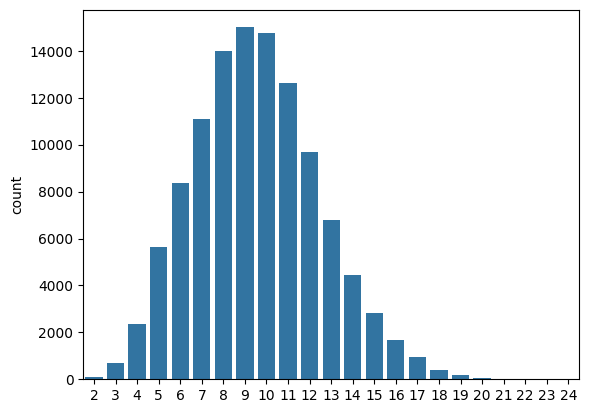

In [11]:
import seaborn as sns
sns.barplot(pd.Series(corpus).str.len().value_counts())

In [12]:
def iter_splits_exact_parts(text: str, num_parts: int, min_part_len: int = 2):
    text_len = len(text)
    if num_parts <= 0 or text_len < num_parts * min_part_len:
        return 
    def search(start_index: int, parts_left: int, current_split: list[str]):
        if parts_left == 1:
            if text_len - start_index >= min_part_len:
                yield current_split + [text[start_index:]]
            return
        max_next_len = text_len - start_index - min_part_len * (parts_left - 1)
        for next_len in range(min_part_len, max_next_len + 1):
            yield from search(
                start_index + next_len,
                parts_left - 1,
                current_split + [text[start_index:start_index + next_len]],
            )
    yield from search(0, num_parts, [])

def all_splits_exact_parts(text: str, num_parts: int = 3, min_part_len: int = 2) -> list[list[str]]:
    return list(iter_splits_exact_parts(text, num_parts, min_part_len))


In [32]:
def create_all_combinations(df, num_parts = 3):
    df['chunks'] = df.corpus.apply(lambda x: all_splits_exact_parts(x, num_parts=num_parts))
    df_exp = df.explode('chunks').dropna(axis=0).reset_index(drop=True)

    cols = [f'chunk{x+1}' for x in range(num_parts)]
    df_exp[cols] = np.stack(df_exp['chunks'].to_numpy())

    return df_exp


def select_valid_elements(df, df_exp, num_parts, filter=True):
    msk = df_exp.chunk1.isin(df['corpus'])
    for i in range(2, num_parts+1):
        msk = msk & df_exp[f'chunk{i}'].isin(df['corpus'])

    if filter:
        for i in range(1, num_parts + 1):
            for j in range(i + 1, num_parts + 1):
                ab = df_exp[f'chunk{i}'] + df_exp[f'chunk{j}']
                ba = df_exp[f'chunk{j}'] + df_exp[f'chunk{i}']
                msk &= ~ab.isin(corpus) & ~ba.isin(corpus)
    
    df_valid = df_exp[msk].drop(columns=['chunks'])
    df_valid = df_valid.loc[
        df_valid[[f'chunk{i}' for i in range(1, num_parts+1)]]
        .apply(lambda row: min(len(x) for x in row), axis=1)
        .sort_values(ascending=False).index
    ]

    return df_valid


In [33]:
df = pd.DataFrame(corpus, columns=['corpus'])

In [34]:
valid_list = []
for num_parts in range(3,6):
    df_exp = create_all_combinations(df, num_parts)
    df_valid = select_valid_elements(df, df_exp, num_parts)
    valid_list.append(df_valid)


df_all_valid = pd.concat(valid_list)
df_all_valid.head()


,corpus,chunk1,chunk2,chunk3,chunk4,chunk5
1853529,ostromlöveganyag,ostrom,löveg,anyag,NaN,NaN
11817,élelmiszerellátás,élelmi,szerel,látás,NaN,NaN
1128155,szentjánosbogár,szent,jános,bogár,NaN,NaN
1670080,kulcshoronyvezeték,kulcs,horony,vezeték,NaN,NaN
23271,torzsmáglyaégetés,torzs,máglya,égetés,NaN,NaN


In [35]:
df_all_valid.to_csv(f'all_filtered_word_comibations.csv', index=False)

In [31]:
len(df_all_valid)

17398

NameError: name 'df_exp' is not defined